## **Importing libraries and datasets**

In [32]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [33]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [34]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [35]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [36]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [37]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [38]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg(recent = ('recent', min),
                                                    customer_id = ('customer_id', lambda x: len(x)),
                                                    tran_amount = ('tran_amount', sum),
                                                    avg_amount = ('tran_amount', lambda x: np.mean(x)),
                                                    trans_date = ('trans_date', lambda x: (x.max() - x.min()).days))

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'avg_amount': 'avg_amount',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [39]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,avg_amount,AOU,ticket_size
0,CS1112,62.0,15,1012,67.466667,1309,67.466667
1,CS1113,36.0,20,1490,74.500000,1354,74.500000
2,CS1114,33.0,19,1432,75.368421,1309,75.368421
3,CS1115,12.0,22,1659,75.409091,1303,75.409091
4,CS1116,204.0,13,857,65.923077,1155,65.923077


## **Calculating response rate**

In [40]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


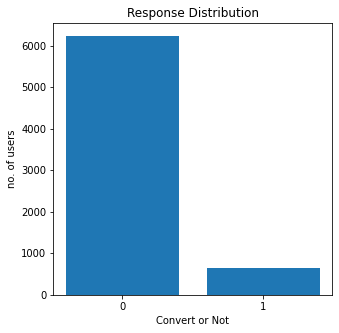

In [41]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [43]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,avg_amount,AOU,ticket_size
0,CS1112,0,62.0,15,1012,67.466667,1309,67.466667
1,CS1113,0,36.0,20,1490,74.500000,1354,74.500000
2,CS1114,1,33.0,19,1432,75.368421,1309,75.368421
3,CS1115,1,12.0,22,1659,75.409091,1303,75.409091
4,CS1116,1,204.0,13,857,65.923077,1155,65.923077


## **Creating train and test dataset**

In [44]:
## spliting dataframe into X and y

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [45]:
## creating train and test dataset

X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

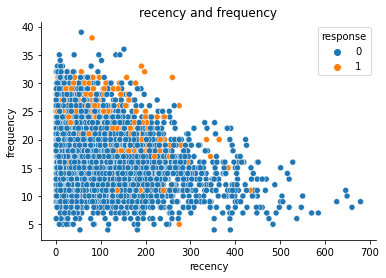

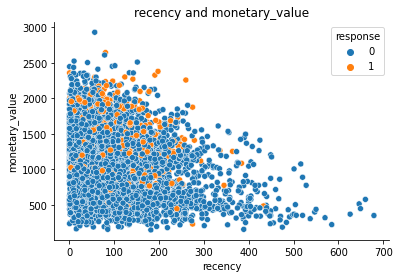

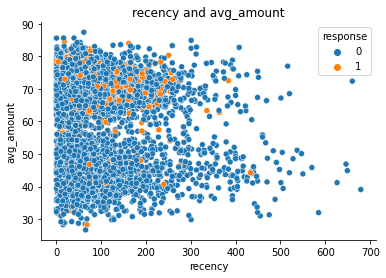

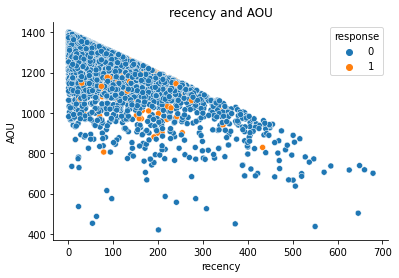

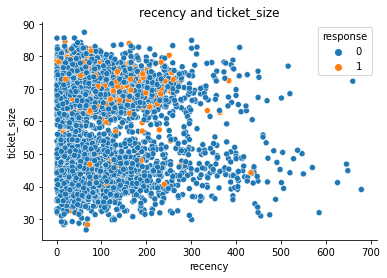

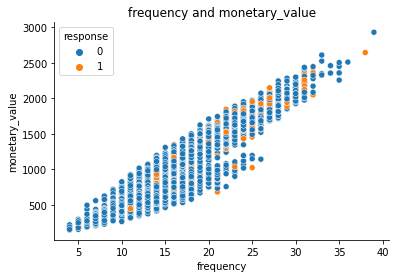

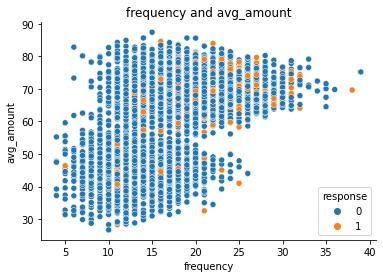

Exception ignored in: <function Booster.__del__ at 0x7f81f451bf80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


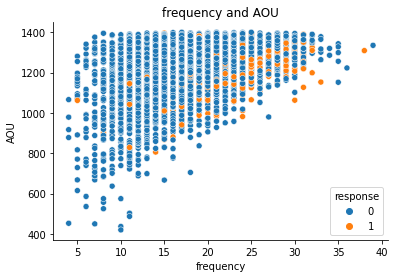

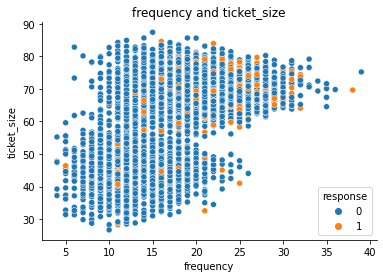

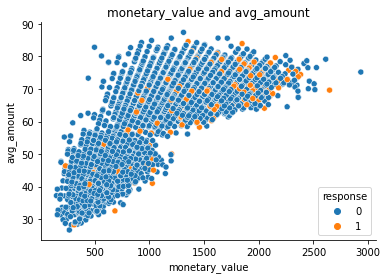

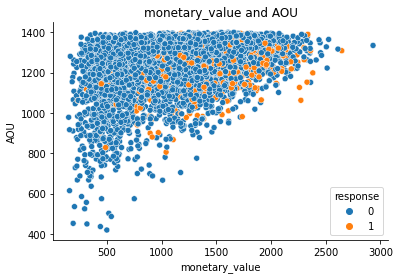

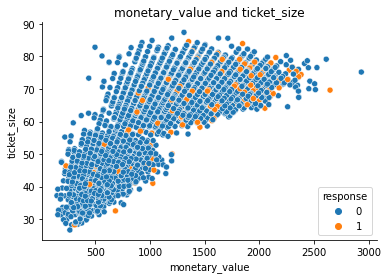

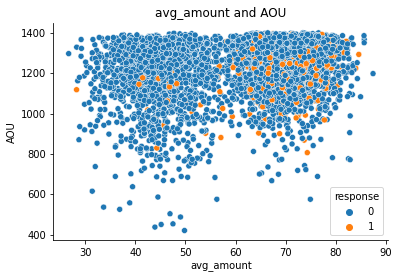

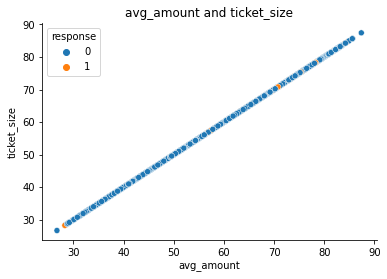

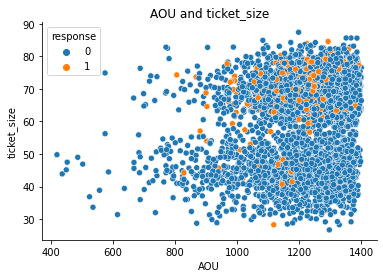

In [46]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'avg_amount','AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'avg_amount','AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [49]:
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=1)

nm1.fit(X_train_clv, y_train_clv)
X_nm1_clv, y_nm1_clv = nm1.fit_resample(X_train_clv, y_train_clv)

## **Logistic Regression**

In [50]:
print('logistic regression model - nm1 CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_nm1_clv = logreg.fit(X_nm1_clv, y_nm1_clv)
predictions = logreg_model_nm1_clv.predict(X_nm1_clv)
predicted_y.extend(predictions)
expected_y.extend(y_nm1_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_nm1_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - nm1 CLV
training set
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       429
           1       0.74      0.64      0.69       429

    accuracy                           0.71       858
   macro avg       0.71      0.71      0.71       858
weighted avg       0.71      0.71      0.71       858

test set
              precision    recall  f1-score   support

           0       0.94      0.54      0.69      1848
           1       0.15      0.68      0.25       218

    accuracy                           0.56      2066
   macro avg       0.54      0.61      0.47      2066
weighted avg       0.85      0.56      0.64      2066



## **XGBoost**

In [51]:
print('XGBoost model - nm1 CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_nm1_clv = xgb_model.fit(X_nm1_clv.values, y_nm1_clv.values, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_nm1_clv.predict(X_nm1_clv.values)
predicted_y.extend(predictions)
expected_y.extend(y_nm1_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_nm1_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - nm1 CLV
[0]	validation_0-auc:0.376447
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.451136
[2]	validation_0-auc:0.514324
[3]	validation_0-auc:0.525171
[4]	validation_0-auc:0.54316
[5]	validation_0-auc:0.542925
[6]	validation_0-auc:0.52082
[7]	validation_0-auc:0.516617
[8]	validation_0-auc:0.523895
[9]	validation_0-auc:0.527388
Stopping. Best iteration:
[4]	validation_0-auc:0.54316

training set
              precision    recall  f1-score   support

           0       0.71      0.89      0.79       429
           1       0.85      0.63      0.72       429

    accuracy                           0.76       858
   macro avg       0.78      0.76      0.76       858
weighted avg       0.78      0.76      0.76       858

test set
              precision    recall  f1-score   support

           0       0.93      0.47      0.63      1848
           1       0.13      0.68      0.22       218

    accuracy                           0.50   

In [52]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [53]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [54]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7097147208215642
[[1089  759]
 [  51  167]]
test set
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      1848
           1       0.18      0.77      0.29       218

    accuracy                           0.61      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.87      0.61      0.68      2066



In [55]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f81e08ef560>}
